## Notebook to compute Secondary Structure of a Cluster

In [1]:
import os
os.chdir('../')

In [6]:
import numpy as np
import json
import pandas as pd
from DB.IPR_LL import db
from generative_models import ProtCNN
from utils import sequence, encoding, aa_ids, cond_names
from tqdm import tqdm
from utils.gui import ss_viz
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
luxa_small_df = db[db.cluster50 == 'P23146']
luxa_small_df = luxa_small_df[luxa_small_df.seq.map(len) > 350]
luxa_small_df.head()

idx                                                seq    name cluster50  \
113  113  MKFGNFLLTYQPPELSQTEVMKRLVNLGKASEGCGFDTVWLLEHHF...  P07740    P23146   
114  114  MKFGNICFSYQPPGESHKEVMDRFVRLGVASEELNFDTFWTLEHHF...  P09140    P23146   
118  118  MKFGNFLLTYQPPQLDQKEVIKRLVNLGQASESCGFDTAWLLEHHF...  P18299    P23146   
119  119  MKFGNFLLTYQPPQFSQTEVMKRLVKLGRISEECGFDTVWLLEHHF...  P19839    P23146   
121  121  MKFGNICFSYQPPGETHKLSNGSLCSAWYRLRRVGFDTYWTLEHHF...  P19907    P23146   

    cluster90                                                 ss    charge  \
113    P07740  CCCCCEEEECCCCCCCHHHHHHHHHHHHHHCCCCCCCHHHHHHCCC... -1.850679   
114    P09140  CCCCCEEEECCCCCCCHHHHHHHHHHHCCCCCCCCCCCEEEHHHHH... -0.906148   
118    P18299  CCCCCEEEECCCCCCCHHHHHHHHHHHHHHHHHCCCCHHHHHHCHH...  0.038383   
119    P23146  CCCCCEEEECCCCCCCHHHHHHHHHHHCCCCHHHCCCHHHHHHCCC...  0.416196   
121    P19907  CCCCCEEEECCCCCCCEECCCCCCCHHHHHHHHCCCCCEEECCCCC... -0.150523   

          iso  mol_weight    length  mol_extinc  proba_ib  
113 -1.161321    0.305583  0.137622    0.775575  1.791209  
114 -0.642859    0.334424  0.122713    0.036549  0.908663  
118  0.120571    0.336416  0.167440    0.583402 -0.590883  
119  0.354952    0.418024  0.212168    0.871661  0.010497  
121 -0.306138    0.330708  0.122713    0.775575 -0.012933

In [8]:
aligned = sequence.align_sequences(luxa_small_df.seq)
aligned_ss = [sequence._align_ss(seq, ss) for (seq, ss) in zip(aligned, luxa_small_df.ss)]
aligned_ss = sequence.rearrange(aligned_ss)

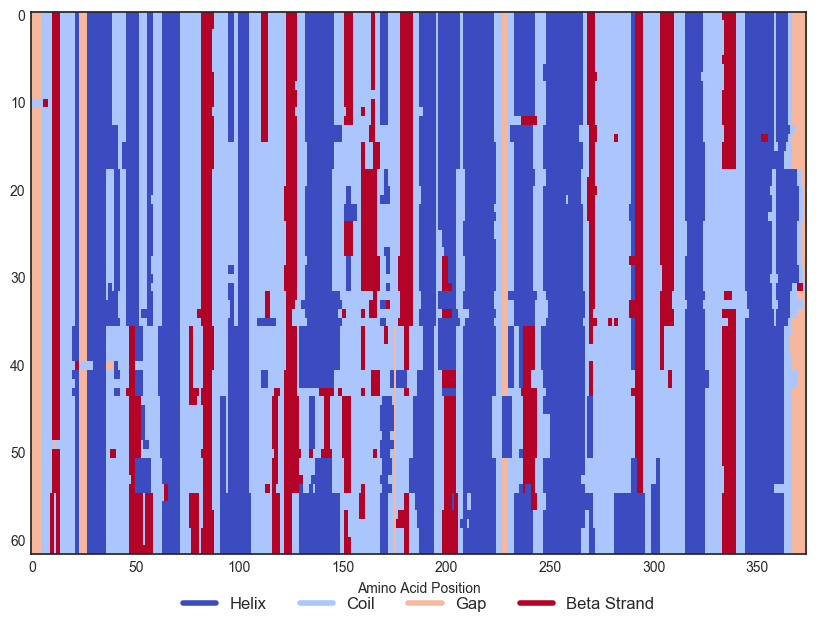

In [10]:
fig, ax = plt.subplots(figsize=(10,10))
fig.set_facecolor('white')
ss_viz(ax, aligned_ss)

### Bokeh view with transparency 

In [13]:
cluster_ss_scores = [sequence.ss_scores(seq) for seq in tqdm(luxa_small_df.seq)]
luxa_cluster_seqs_aligned = sequence.align_sequences(luxa_small_df.seq)
n = len(luxa_cluster_seqs_aligned)
size = len(luxa_cluster_seqs_aligned[0])
scores_matrix = np.zeros((n, size, 4))
for i, s in enumerate(cluster_ss_scores):
    mask = np.array(list(luxa_cluster_seqs_aligned[i])) != '-'
    scores_matrix[i,mask,:3] = s.T
scores_matrix = np.array(sequence.rearrange(scores_matrix, distance_function = 
                                  lambda x, y:np.linalg.norm(x-y)))

100%|██████████| 62/62 [00:54<00:00,  1.17it/s]


In [14]:
img = np.empty((n, size), dtype=np.uint32)
view = img.view(dtype=np.uint8).reshape((n, size, 4))

for i in range(n):
    for j in range(size):
        view[-i, j, 0] = int(255*scores_matrix[i, j, 2])
        view[-i, j, 1] = int(255*scores_matrix[i, j, 0])
        view[-i, j, 2] = int(255*scores_matrix[i, j, 1])
        x = sorted(scores_matrix[i, j])
        view[-i, j, 3] = int(255*(x[-1] - x[-2]))

In [16]:
from bokeh.plotting import figure
from bokeh.io import show, output_notebook
output_notebook()
p = figure(title="LuxA Cluster Secondary Structure View",plot_height=500,plot_width=700,
            x_range = (0, size), y_range = (0, n), x_axis_label='Sequence Position',
          y_axis_label='Sequences')
p.image_rgba(image=[img], x=[0], y=[0], dw=[size], dh=[n])
show(p)

Loading BokehJS ...

bokeh.models.renderers.GlyphRenderer(
    id='6706b558-8899-41fd-962f-c65762e31046',
    data_source=bokeh.models.sources.ColumnDataSource(
        id='051f38a8-e0b9-4d3e-b4b0-eafa034978f8',
        callback=None,
        data={'dh': [62],
         'dw': [374],
         'image': [{'__ndarray__': 'AAAAAAAAAAAAAAAAAAAAAAAAAAAA/gD+H9cGuDW7DIYhxRSkQKIcYqdEC2K3NwmAmFETRqpFC2VomgUxDvMB5QH7AfoB9gPzBNEuowSeYzoBs1JhABDt3AEM8eQAAAAAAAAAAAAAAAAAAAAAAAT69gAC/PoAAvz5AAL8+gAC/PoABfnzARjmzQE0ypYBU65bAVSpVQEZ5MoCK9OoAphtKwLcI7kE5B3HBOgT1QP4A/UHrlBeDr06ggkY28ItF9eqGwvu0w8R5tURKcSbTye1Zjd4RDQzYHERDqlAaQubVUYJUaRTCFyVOQxpfhQJimgiBtAspALuDuAC9QfuARDs2wkO8OEDA/r3AQL9+wEC/PoBAvz6AQT69gEM8+YCVqtVAtYhtA/PIK4Vb28ALKUseDy2FXlujQMeYqgDRUW3CXFSqglXdYAGC9MdCbbwCgLl9AcC7e4MAuHANgSKfn0GACLVBrIJ8QToBvUD7wjHL5cMxSidFrQyghm2M4MIXIgrCF6PMARNq10Eq1FaBOUYzAFJtGsHLs2eAhXo0wIL8ucDMcyaAqBmOQPOMJ4E9ArpGtIPuDqlL2sxvROMgF45IXtsIQ+JYRQoaH4mFSK2IpMjsiyFGqM8ZxS8KZMN1xXBCeQYyxfeCsZphQsbsj0JddscBL/ZHAW8qFkCTo9wBB4i2gS4Cu4G5APaJrMBvEZ1AVubQAIT6dYCB/fwAAX59AAD+/cAA/v4AAP7+AAB/fsAAf38AAH9+wAE+/cACfXrARbo0gCAiAgBvUR5BbRQYwynSl0ctjaAGNsLw4drCRyoSwhdwysPmKlNB1w5uA1+DscloQrKK581qSN0eIIJCm+QAyEW6gLTHugCyXCBCRGPbAQitUUDcIGJAgcn2AOwAlWmUARfmDkFOrh+G254CR50Zg0Qti6ICO4H5g3vA+Iv0wOkbpMBJNEmAqv3BwDv+wQA9/oEAPbwDQDitkcCbynHDJ0YyiihFKVLWQluhRYCLsydAQn06gAH9+8AA/v3AAP79wAK9OkAR7t0APcG8ABkmzcDL9GiEBrfxRsF89gGAvz1BgT68woO69wGC/PnBTnCiQNBuXgBPcOFAatYUwFnkywCLM+iBinRpwZPplcHHdy+CBbo0Qsnz6cHQbVzBA3x5AIV6NICDPHlAg7x4gMV6dQCDvDiAybYsQKWbSgC9QbuEO0D3R/XBbgAAAAAAAAAAAAAAABdgxEmfU9DLjp7USoQMbeFD2p+EwY2v4kDDfDjBxLq1wgS6dcGGeTLEzixeRlAqGgoX3kaKKUteBLgCM4G7gfmAfEI6QGtV1YBMseVARbn0AET69gABvjyAAP7+AAD+/gAAvz6AAf48AAG+PEBE+rWAD69fgEZ48oCFufQAyXWsAMK9OkGIODABlShTQ9bjTI2dmYQLaMndmxnKAS7LBuOzCIVqYVaJCo2ygWUEewD2wTfH8ADxTqKA65WVwbCM48PyyWmDdoYwRzgBsRDtghzUbMEYiDXB7YL2hjCB80xnBasNXdhf0YdfkpdIUo3lEkyO4dMwxkhodsGI7fmDQjZsjQNfkK5B3YuywudFNQTvwzaFMYJ0ySuCt4VyCHNEKtUmBhDnlMHS6JWA0vBNQOL5hUB0O4OAd/rEgHZqGEBRjvRApUK9ALqA/gB9QH7AfoA+gL4AA7w4gEL9OgBBvnzCAj07FcQtV5REalYKhPQpl0jrlBqN4YcPIZLOheYRlEJe3MHBp9WSAm5PXsHujt/CO0J4xHaD8gi0Q2vfGgaE7c7CHuEdQcOtToKeqtOBF2ZYAU4m14FPD++BH4K7wTlAfoB+AH3A/QADfHkAg3y5QEE+vYCAvz5AwX48gUF+fMLC/HlCgz05x8pwJcgINGwES7GmA01vIcGV6RNBG2PIQSkXUYCLNGkAhfnzwIW59ADJNi0BUuwZAdujiADnWE7AP4A/gAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD+AP4wxgWWV5ALOWhxGQmjOhlosjYIe1SYCEOAbg8Rk2UHLUa5BXMK9QHrAfsB+gD7AfoB+QL3ApVxIwKdaDUBDu/hAAP79wAAAAAAAAAAAAAAAAAAAAAAAf37AAH9/AAB/fwAAvz6AAP8+QAG+PEDC/TpBg7u3wgn2LEGr0BuI7AijU6lDVaBcwkOcoASDoJeSyNBmi9ZEuUH0g7nCdkK8QTmMcASjqxGBWXlFAPR7w0B4qM+H2TFKRSc2hsKv5hCK1ZlYTEDlTlDUWtWORRuWzITh2YNIUitCWU2vg2IJqI9ZCKJWTAQFObSMgfirykP27IcCezQHifJogsO7d8HCvTpCBvixgQ9voAFqUVkDsserBnWCbwj1wW0cogEFrNIAmvKLgOc0yQEr8g0ApRJuQJviXADGNElA6ztDwHe4BsCxMk2ApO4SAJvIN8CvwXxB+oB9wTzAC7RogBDvnoCNMeTB2yGGhErwZUUFeLNEw/q1wsK8+cTD+vXEwzu2yEM7cwkGtizJRLjvQs3xI0GdoILBMs8jwT2BfEQ6QTYG9wGwCHODKwbnT9dIpg9WjZ+SDZLjTlBOasbcZZNHkmZSxxOrEISarM6FnkfxhanPMIJhaNQBFPOKASmuD8FecUwBZV2mQEjHuMCxQT0BO8AEO3dAAv06AAK9OkACPbtAAvz5wAD+/gAAf37AAL8+gAG+fMADfDjAAr06gAI9u4BB/fvAQ3y5QQL8+cELNGlAz3AgwMwzZwDINu6BjHPngiqPW0Y2wfCu0QCdsstBJ6rVANWMNYDpgv0AugI9AbrI9cHs1CnA1ZhrQNMKtwCsQ3wAuIK8gPoFOEKzUiiHllPlhVHSLAOaB7WELcDHdK0Fx/OrhQY3MMcbXgKEbYjkw3cEMwT0RC9AAAAAAvwA+QK9wHtSrAGZXWIBhKuRAdpjnQDGWmWBi0wwQyQFcQrmA+3OX0apDpqPT2fYTQN5K8SB/TiCQnx6AYO7d8FFuTOBTPIlQKdaTQB+QXzB/EI6CDPDK59YycZ1hwKue0NA+DrDAnf6Q4E26ApRVuwJzZ5uDkNfy+BPkMcilgxCUukWBZBqmlkU1YOUzd4JTQevYkhNbaBIBPjwhAQ6toGDfDiAg3w4wEI9e0BB/fwAQj27QEG+PIBEO/fAW+UJAHvEN4D7A/dB+kK3gAAAAAAAAAAAAAAAAuoU1QLqk5cCbBMYwQ6voQKJ9KrBxDr2g8J8eIZCvDWGQrw1yEJ8M8VDe7YFxfiyg2IZiIKsD5xAfQG7QHiI74Bw0GCAA3w4wAH+PAAB/fwAAf38AAH9/AAAvz6AAH9+wAC/PoAAvz6AAH9+wAB/fsAAvz6AAn17AEQ7t4AKtOoAQn17AER7t0BNciTAYl7DgOQcB8HplNTE3VuBicuwJEtJsaZGTqtcgnCJZwL2xbEBcgzlAK8R3UCnWE7A69TXAmhV0kJtERvBt4ewAIj17QHJNeyAg7v4QEI9u0AA/v3AAH9+wAB/fsAAf37AAH9/AAB/fsAAvz6AAf37wEH9+8BJNm0AH2GCAGgZDwC3ie3AvcG8AE9wYQGPL6CAyzNoQhTlkMSm0FaGLUuhgzKIagJ1CatB9MpqgzbHb0W0hG8C+0E4gfzA+wE9gLxAfsB+QD6AvgAEuzaAQvz6AAE+vUBA/v4AQL8+g